In [1]:
from pathlib import Path

import numpy as np
from astropy.io import fits
from astropy.nddata import CCDData
from astropy.visualization import (MinMaxInterval, PercentileInterval,
                                   AsymmetricPercentileInterval, ImageNormalize)

from matplotlib import pyplot as plt

from keckdata import KeckData, KeckDataList, fits_reader, split_fits_section

/Users/jwalawender/anaconda/lib/python3.6/site-packages/scipy/__init__.py:115: UserWarning: Numpy 1.13.3 or above is required for this version of scipy (detected version 1.11.3)
  UserWarning)


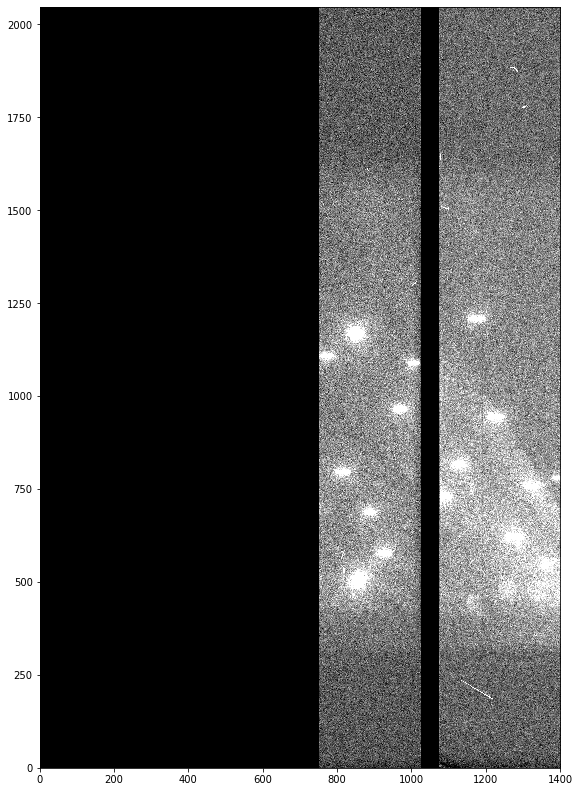

(2, 2)

In [19]:
## DEIMOS
# fitsfile = Path('/Volumes/JOSHW/Examples/DEIMOS/deimos.fits')
# fitsfile = Path('/Volumes/JOSHW/Examples/DEIMOS/d1026_0037.fits')
# fitsfile = Path('/Volumes/JOSHW/Examples/DEIMOS/d1026_0038.fits')
# fitsfile = Path('/Volumes/JOSHW/Examples/DEIMOS/d1026_0039.fits')

## LRIS Blue
# fitsfile = Path('/Volumes/JOSHW/Examples/lris_blue.fits')
# fitsfile = Path('/Volumes/JOSHW/Examples/LRIS/2019oct26/bfoc_0001.fits')
# fitsfile = Path('/Volumes/JOSHW/Examples/LRIS/2019oct26/b191026_0008.fits')
# fitsfile = Path('/Volumes/JOSHW/Examples/LRIS/2019oct28/b191028_0005.fits')
# fitsfile = Path('/Volumes/JOSHW/Examples/LRIS/2019oct31/b191031_0004.fits')
# fitsfile = Path('/Volumes/JOSHW/Examples/LRIS/2019oct31/b191031_0005.fits')
# fitsfile = Path('/Volumes/JOSHW/Examples/LRIS/2019oct31/b191031_0006.fits')

## LRIS Red
# fitsfile = Path('/Volumes/JOSHW/Examples/lris_red.fits')
# fitsfile = Path('/Volumes/JOSHW/Examples/LRIS/2019oct26/rfoc_0001.fits')
# fitsfile = Path('/Volumes/JOSHW/Examples/LRIS/2019oct26/r191026_0008.fits')
# fitsfile = Path('/Volumes/JOSHW/Examples/LRIS/2019oct31/r191031_0001.fits')
# fitsfile = Path('/Volumes/JOSHW/Examples/LRIS/2019oct31/r191031_0002.fits')
# fitsfile = Path('/Volumes/JOSHW/Examples/LRIS/2019oct31/r191031_0003.fits')
# fitsfile = Path('/Volumes/JOSHW/Examples/LRIS/2019oct31/r191031_0004.fits')
# fitsfile = Path('/Volumes/JOSHW/Examples/LRIS/2019oct31/r191031_0005.fits')
# fitsfile = Path('/Volumes/JOSHW/Examples/LRIS/2019oct31/r191031_0006.fits')
fitsfile = Path('/Volumes/JOSHW/Examples/LRIS/2019oct31/r191031_0007.fits')




## HIRES
# fitsfile = Path('/Volumes/JOSHW/Examples/hires1.fits')
# fitsfile = Path('/Volumes/JOSHW/Examples/hires2.fits')
# fitsfile = Path('/Volumes/JOSHW/Examples/hires3.fits')

kd = fits_reader(fitsfile)
kd.iraf_mosaic(fordisplay=True, zero=True)
norm = ImageNormalize(kd.mosaic, interval=AsymmetricPercentileInterval(0.5,99))
plt.figure(figsize=(14,14))
plt.imshow(kd.mosaic, origin='lower', norm=norm, cmap='gray')
plt.show()
binx, biny = kd.binning()
binx, biny

In [20]:
binx, biny = kd.binning()
binx, biny

(2, 2)

In [21]:
xgap = int(20 / binx)
ygap = int(20 / biny)
fordisplay = True
zero = True

In [22]:
CCDs = {}
for i,pd in enumerate(kd.pixeldata):
    CCDNAME = pd.header.get('CCDNAME')
    EXTNAME = pd.header.get('EXTNAME')
    DETSEC = pd.header.get('DETSEC')
    DATASEC = pd.header.get('DATASEC')
    if CCDNAME not in CCDs.keys():
        CCDs[CCDNAME] = {'CCDNAME': CCDNAME,
                         'EXTNAMES': [EXTNAME],
                         'DETSECS': [DETSEC],
                         'DATASECS': [DATASEC],
                         'PDid': [i],
                        }
    else:
        CCDs[CCDNAME]['EXTNAMES'].append(EXTNAME)
        CCDs[CCDNAME]['DETSECS'].append(DETSEC)
        CCDs[CCDNAME]['DATASECS'].append(DATASEC)
        CCDs[CCDNAME]['PDid'].append(i)

CCDs

{'19-3': {'CCDNAME': '19-3',
  'EXTNAMES': ['VidInp2'],
  'DETSECS': ['[1501:2050,1:4096]'],
  'DATASECS': ['[4:278,1:2048]'],
  'PDid': [0]},
 '19-2': {'CCDNAME': '19-2',
  'EXTNAMES': ['VidInp4'],
  'DETSECS': ['[2049:2702,1:4096]'],
  'DATASECS': ['[4:330,1:2048]'],
  'PDid': [1]}}

In [23]:
# Form an intermediate CCDSEC which is the position of the data
# within each CCD (i.e. combine the amps)
for CCD in CCDs.keys():
    ccd_sec = None
    for j,extname in enumerate(CCDs[CCD]['EXTNAMES']):
        DETSEC = split_fits_section(CCDs[CCD]['DETSECS'][j])
        if ccd_sec is None:
            ccd_sec = {'x1': DETSEC['x1'],
                       'x2': DETSEC['x2'],
                       'y1': DETSEC['y1'],
                       'y2': DETSEC['y2'],
                       }
        else:
            ccd_sec['x1'] = min([ ccd_sec['x1'],  DETSEC['x1'] ])
            ccd_sec['x2'] = max([ ccd_sec['x2'],  DETSEC['x2'] ])
            ccd_sec['y1'] = min([ ccd_sec['y1'],  DETSEC['y1'] ])
            ccd_sec['y2'] = max([ ccd_sec['y2'],  DETSEC['y2'] ])
        print(CCDs[CCD]['DETSECS'][j])
        print(ccd_sec)
    CCDs[CCD]['CCDSEC'] = ccd_sec
# Figure out the grid parameters of the chips in the "detector" focal plane
chips = []
for CCD in CCDs.keys():
    CCDSEC = CCDs[CCD]['CCDSEC']
    chips.append( [CCD,
                   int(np.ceil(CCDSEC['x1']/binx)),
                   int(np.ceil(CCDSEC['x2']/binx)),
                   int(np.ceil(CCDSEC['y1']/biny)),
                   int(np.ceil(CCDSEC['y2']/biny)),
                  ] )
chips.sort(key=lambda c: c[3])
chips.sort(key=lambda c: c[1])

x1s = sorted( list( set( [c[1] for c in chips] ) ) )
y1s = sorted( list( set( [c[3] for c in chips] ) ) )
chip_grid = (len(x1s), len(y1s))
ngrid = len(x1s) * len(y1s)
assert ngrid == len(CCDs)

CCDs

[1501:2050,1:4096]
{'x1': 1501, 'x2': 2050, 'y1': 1, 'y2': 4096}
[2049:2702,1:4096]
{'x1': 2049, 'x2': 2702, 'y1': 1, 'y2': 4096}


{'19-3': {'CCDNAME': '19-3',
  'EXTNAMES': ['VidInp2'],
  'DETSECS': ['[1501:2050,1:4096]'],
  'DATASECS': ['[4:278,1:2048]'],
  'PDid': [0],
  'CCDSEC': {'x1': 1501, 'x2': 2050, 'y1': 1, 'y2': 4096}},
 '19-2': {'CCDNAME': '19-2',
  'EXTNAMES': ['VidInp4'],
  'DETSECS': ['[2049:2702,1:4096]'],
  'DATASECS': ['[4:330,1:2048]'],
  'PDid': [1],
  'CCDSEC': {'x1': 2049, 'x2': 2702, 'y1': 1, 'y2': 4096}}}

In [24]:
# Using the CCDSEC info, form the data for each CCD chip
unit = set([pd.unit for pd in kd.pixeldata]).pop()
meanlv = None
for CCD in CCDs.keys():
    CCDSEC = CCDs[CCD]['CCDSEC']
    ccd_size_y = int((CCDSEC['y2'] - CCDSEC['y1'] + 1)/biny)
    ccd_size_x = int((CCDSEC['x2'] - CCDSEC['x1'] + 1)/binx)
    print(ccd_size_x, ccd_size_y)
    CCDs[CCD]['data'] = CCDData(data=np.zeros((ccd_size_y, ccd_size_x)), unit=unit )
    for j,extname in enumerate(CCDs[CCD]['EXTNAMES']):
        PDid = CCDs[CCD]['PDid'][j]
        DETSEC = split_fits_section(CCDs[CCD]['DETSECS'][j])
        DATASEC = split_fits_section(CCDs[CCD]['DATASECS'][j])
        print(DETSEC['y1']-1, DETSEC['y2'], DETSEC['x1']-1, DETSEC['x2'])
        print(DATASEC['y1']-1, DATASEC['y2'], DATASEC['x1']-1, DATASEC['x2'])
        imagesection = kd.pixeldata[PDid][DATASEC['y1']-1:DATASEC['y2'], DATASEC['x1']-1:DATASEC['x2']]
        if DETSEC['xreverse'] is True:
            imagesection.data = np.fliplr(imagesection.data)
        if DETSEC['yreverse'] is True:
            imagesection.data = np.flipud(imagesection.data)
        if fordisplay is True:
            if meanlv is None:
                meanlv = np.percentile(imagesection.data, 0.1) if zero is False else 0
            imagesection -= np.percentile(imagesection.data, 0.1) + meanlv
        DETSEC['x2'] -= (CCDSEC['x1']-1)
        DETSEC['x1'] -= (CCDSEC['x1']-1)
        DETSEC['y2'] -= (CCDSEC['y1']-1)
        DETSEC['y1'] -= (CCDSEC['y1']-1)
        print(imagesection.data.shape)
        print(DETSEC)
        print(CCDs[CCD]['data'].data[DETSEC['y1']-1:DETSEC['y2'], DETSEC['x1']-1:DETSEC['x2']].shape)
        CCDs[CCD]['data'].data[DETSEC['y1']-1:DETSEC['y2'], DETSEC['x1']-1:DETSEC['x2']] = imagesection.data

# CCDs

275 2048
0 4096 1500 2050
0 2048 3 278
(2048, 275)
{'x1': 1, 'x2': 550, 'y1': 1, 'y2': 4096, 'xreverse': False, 'yreverse': False}
(2048, 275)
327 2048
0 4096 2048 2702
0 2048 3 330
(2048, 327)
{'x1': 1, 'x2': 654, 'y1': 1, 'y2': 4096, 'xreverse': False, 'yreverse': False}
(2048, 327)


In [25]:
# Assemble the "detector" mosaic
for i,chip in enumerate(chips):
    CCD, CCDx1, CCDx2, CCDy1, CCDy2 = chip
    gridxpos = x1s.index(CCDx1)
    gridypos = y1s.index(CCDy1)
    CCDSEC = CCDs[CCD]['CCDSEC']
    CCDx1 += (2*gridxpos-1)*xgap if gridxpos > 0 else 0
    CCDx2 += (2*gridxpos+1)*xgap if gridxpos < len(x1s)-1 else (2*gridxpos)*xgap
    CCDy1 += (2*gridypos-1)*ygap if gridypos > 0 else 0
    CCDy2 += (2*gridypos+1)*ygap if gridypos < len(y1s)-1 else (2*gridypos)*ygap
    chips[i] = [CCD, CCDx1, CCDx2, CCDy1, CCDy2, gridxpos, gridypos]

# CCDs

In [26]:
xmax = max([chip[2] for chip in chips])
ymax = max([chip[4] for chip in chips])
# print(chips)
mosaic = CCDData(data=np.zeros((ymax, xmax)), unit=unit )
for i,chip in enumerate(chips):
    CCD, CCDx1, CCDx2, CCDy1, CCDy2, gridxpos, gridypos = chip
    MOSx1 = CCDx1+xgap-1 if gridxpos > 0 else CCDx1-1
    MOSx1 = max( [MOSx1, 0] ) # Ensure we're above 0
    MOSx2 = MOSx1 + CCDs[CCD]['data'].data.shape[1]
    MOSy1 = CCDy1+ygap-1 if gridypos > 0 else CCDy1-1
    MOSy1 = max( [MOSy1, 0] )
    MOSy2 = MOSy1 + CCDs[CCD]['data'].data.shape[0]
#     print()
#     print(CCDx1, CCDx2, gridxpos, CCDx1+xgap-1)
#     print(MOSx1, MOSx2)
    mosaic.data[MOSy1:MOSy2,MOSx1:MOSx2] = CCDs[CCD]['data'].data
    
# mosaic.data

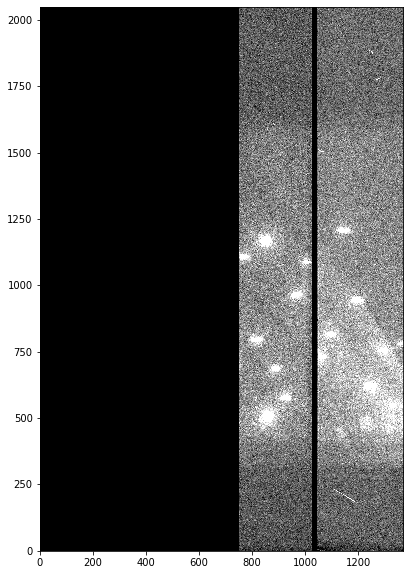

In [27]:
norm = ImageNormalize(mosaic, interval=AsymmetricPercentileInterval(2, 99))
plt.figure(figsize=(14,10))
plt.imshow(mosaic, norm=norm, cmap='gray', origin='lower')
plt.show()